<a id='rotterdam'></a>
## TSP Rotterdam

In this example, we will use a map containing Rotterdam's city center and surroundings. TSP will be used to find the optimal path for selected locations in the city. For simplicity, aerial distance will be used. Although, this can be altered by adding a table containing distances in kilometers for every location pair.

Let us start with importing a few modules that we will need:

In [1]:
import itertools
import math
import random

import matplotlib.pyplot as plt

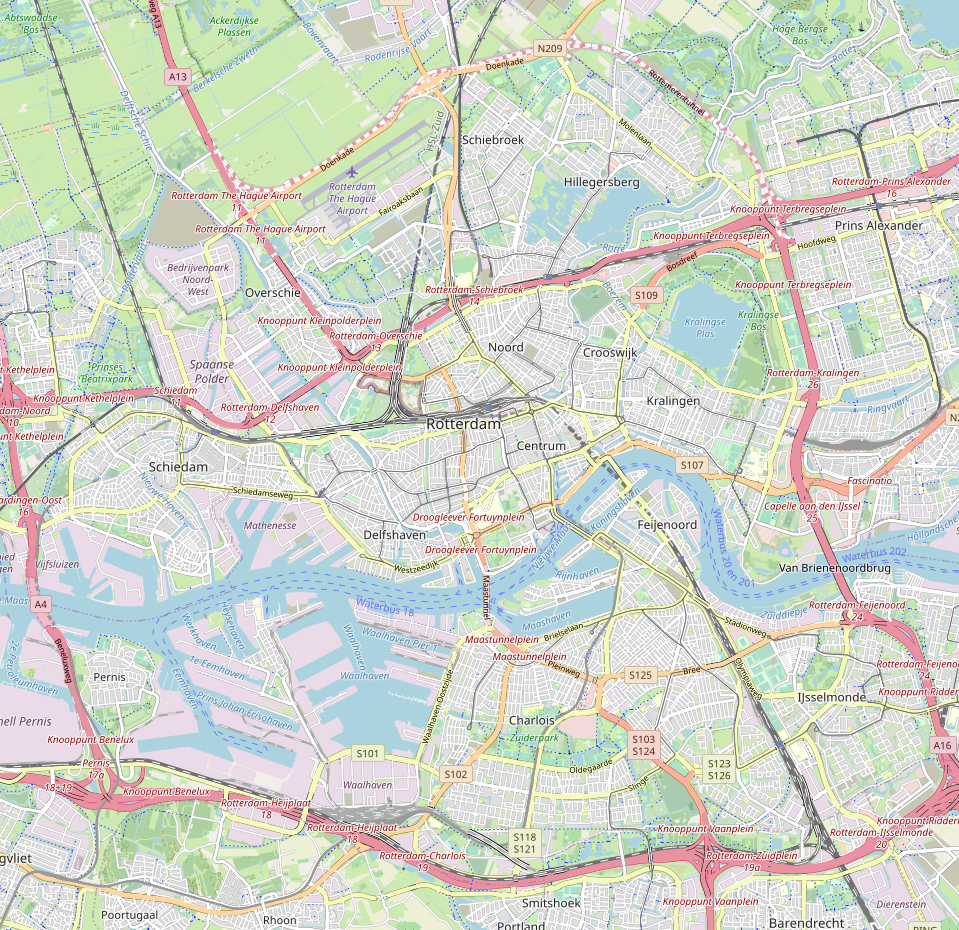

Pyplot can easily load images and plot on top of those. Function `plot_map()` loads map image from a given file, uses bounding box to set proper latitude and longitude on the axes and then plots it.

In [2]:
def plot_map(map_file, BBox):
    tsp_map = plt.imread(map_file)
    ax = plt.gca()

    ax.imshow(tsp_map, zorder=0, extent = BBox, aspect='auto')

The image above is an attachment to the notebook.  We will use the following workaround to retrieve it in our code: read this entire notebook as a dictionary, locate and extract the attached image, and then convert base64 to .png.

Note: Just run the cell. How it works is of no interest for TSP problem.

In [3]:
def load_from_jupyter_attachment():
    # Several libraries are needed to convert different file types
    import io
    import nbformat
    import base64

    # Load this notebook as dictionary
    with io.open("tsp_rotterdam.ipynb", 'r', encoding='utf-8') as f:
        nb = nbformat.read(f, as_version=4)

    # Find the cell containing map and extract the data from the attachment
    data = None
    for cell in nb.cells:
        if 'attachments' in cell:
            if 'map.png' in cell.attachments:
                data = cell.attachments['map.png']['image/png']
                break
    if data:
        return io.BytesIO(base64.b64decode(data))
    return None

map_path = load_from_jupyter_attachment()

Once the file is loaded, it can be plotted.

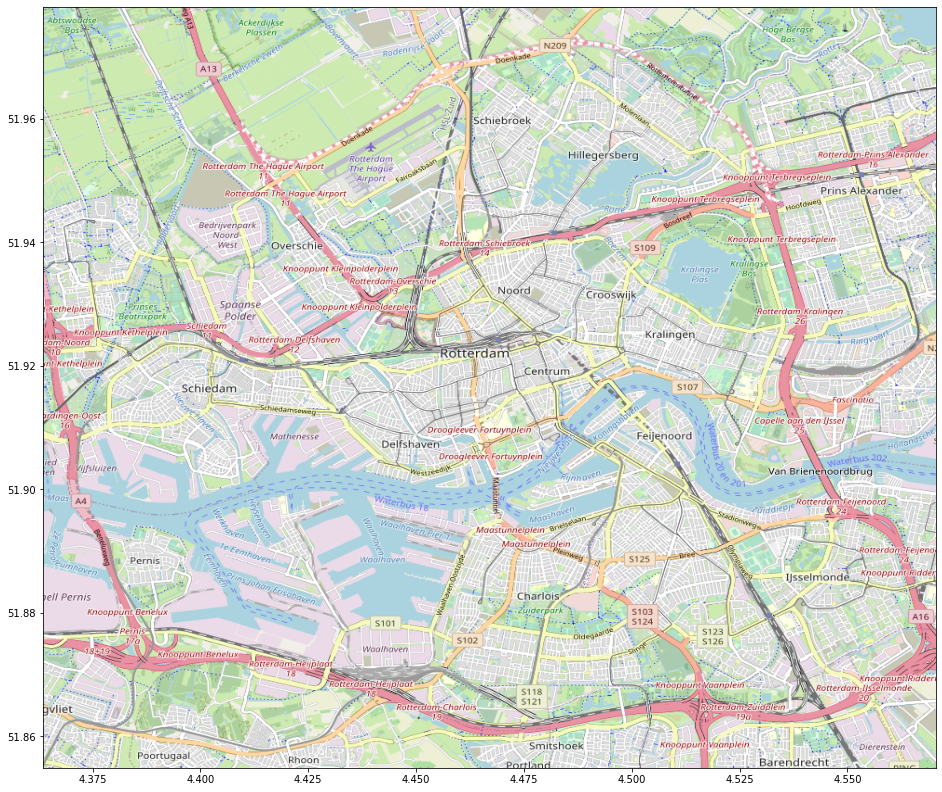

In [4]:
# These are hard-encoded values tailored for our specific map of Rotterdam
map_BBox = (4.3635, 4.5705, 51.8549, 51.9781)

fig, ax = plt.subplots(figsize = (16,14))
plot_map(map_path, map_BBox)
plt.ion()
plt.show()

Let us add some locations. Since we are no longer in 2D Cartesian coordinate systems, (x, y) pairs must be replaced with the appropriate latitude and longitude values.

Note: In geography, coordinates are given as (**LAT**itude, **LON**gitude), while on 2D map, LAT is plotted on Y axis and LON is plotted on X axis.

In [5]:
locations = ((51.917362, 4.483990, "Hogeschool Rotterdam"),
                (51.905919, 4.466186, "Euromast"),
                (51.893808, 4.522941, "Stadion Feijenoord"),
                (51.925119, 4.468844, "Rotterdam centraal"),
                (51.882739, 4.488112, "Ahoy"),
                (51.921297, 4.409519, "Schiedam Centrum"),
                (51.953358, 4.440102, "Rotterdam airport"),
                (51.949503, 4.554648, "Alexandrium")
                )

To avoid possible lat / lon confusion and make the code easier to read, it is good practice to add few more helper functions.

In [7]:
def get_lat(point):
    return point[0]

def get_lon(point):
    return point[1]

def list_x(all_points):
    return [get_lon(p) for p in all_points]

def list_y(all_points):
    return [get_lat(p) for p in all_points]

Let us plot our Rotterdam map to include the given locations.

In [8]:
map_BBox = (4.3635, 4.5705, 51.8549, 51.9781)
map_path = load_from_jupyter_attachment()

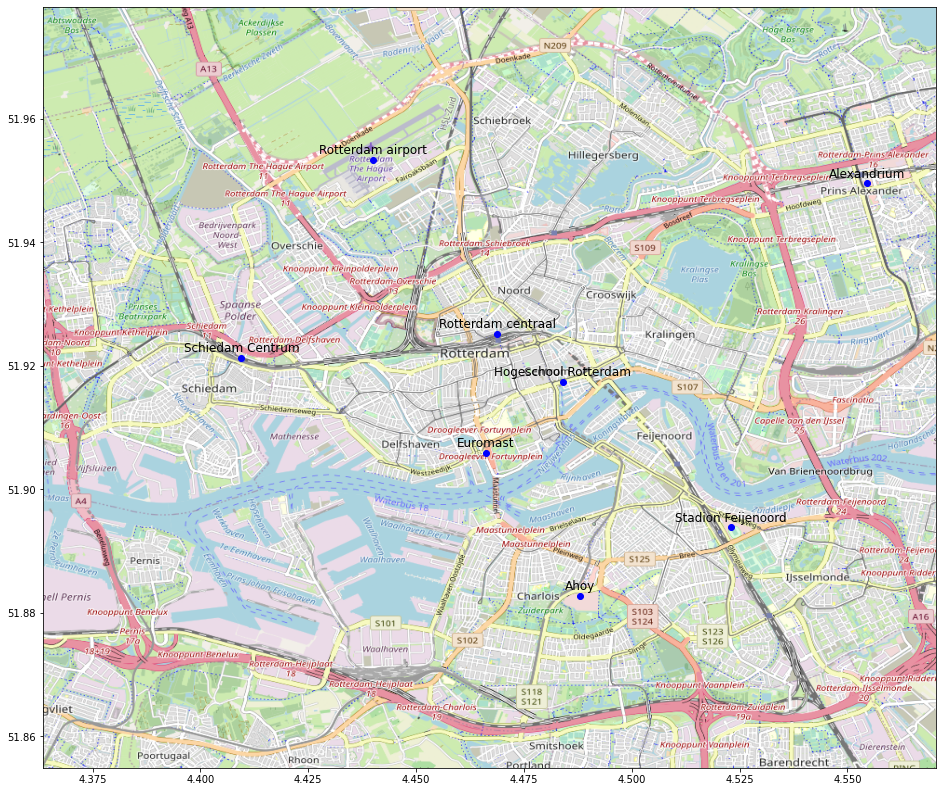

In [9]:
# Set figure size
fig, ax = plt.subplots(figsize = (16,14))
# Plot our Rotterdam map; note: we need map_path and map__BBox
plot_map(map_path, map_BBox)

# Convert LON and LAT to X,Y lists, and plot locations
X = list_x(locations)
Y = list_y(locations)
plt.plot(X,Y, "bo")

# It is nice to label the points as well
def write_text(x, y, text, Xoffset = 0, Yoffset = 0, font_size = 12):
    """ Writes given text (str) at given (x,y) coordinates """
    plt.text(x+Xoffset,y+Yoffset,text, horizontalalignment='center', size=font_size)

for p in locations:
    write_text(get_lon(p), get_lat(p), p[2], Yoffset = 0.001)

# Show plot
plt.ion()
plt.show()

<a id='haversine'></a>
## Haversine distance

Earth is not flat, nor a disc. Therefore, Euclidean distance cannot be used to measure the distance of two points, if those are given as latitude and longitude pairs. To solve this problem, we use **Haversine formula** (or **Haversine distance**), which computes the shortest great circle distance between two points on the globe, designated by latitudes and longitudes. If you want to know more about this topic, you can start from [Wikipedia: Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula).

In Geography we label latitude and longitude with the following symbols:
$$\phi = \text{latitude}$$
$$\lambda = \text{longitude}$$

With **Haversine formula**, we calculate the **central angle, θ**, between two points ***p*** and ***q***, where ***p*** is given as *(ϕ<sub>1</sub>, λ<sub>1</sub>)* and ___q___ is given as _(ϕ<sub>2</sub>, λ<sub>2</sub>)_. 

$$\theta=2\cdot \arcsin \left( \sqrt{\sin^2 \left(\frac{\phi_2-\phi_1}{2} \right)+\cos(\phi_1)\cdot \cos(\phi_2)\cdot \sin^2 \left(\frac{\lambda_2-\lambda_1}{2} \right)} \right)$$

The distance, **d**, is then calculated as: $$d=r \cdot \theta,$$ where **r** is the radius of Earth and is approximately equal to ≈6371 km.

Note: the "Earth radius" r varies from 6356.752 km at the poles to 6378.137 km at the equator.

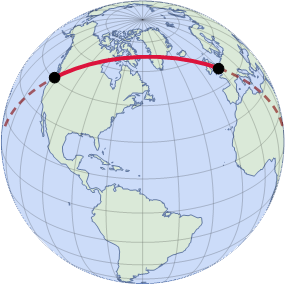
<center>( Image source: https://software.intel.com/sites/default/files/great%20circle.png )</center>

Detailed explanation about **Haversine formula** with code examples can be found on the following pages: [Calculate distance, bearing and more between Latitude/Longitude points](http://www.movable-type.co.uk/scripts/latlong.html) and [Calculate the GPS Distance with the Haversine Formula](http://mathyourlife.github.io/spouting-jibberish/Haversine/Haversine.html).

Once the formula is known, it can be easily written as Python function.

In [10]:
# Mean radius of the earth
EARTH_RADIUS = 6371.009

def haversine(p1, p2):
    """ Calculate the great circle distance between two points on Earth
    Returns central angle and distance in km"""
    
    # extract lat and lon from points
    lat1 = get_lat(p1)
    lon1 = get_lon(p1)
    lat2 = get_lat(p2)
    lon2 = get_lon(p2)

    # convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = [math.radians(x) for x in [lat1, lon1, lat2, lon2]]

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    central_angle = 2 * math.asin(math.sqrt(a))

    # d = r * theta
    km = EARTH_RADIUS * central_angle
    return km

Test it on the known distances. For example, the distance from Rotterdam centraal to Schiedam Centrum is ≈ 4.09 km, and the distance from Alexandrium to Ahoy is ≈ 8.71 km.

In [11]:
p = locations[3]        # Rotterdam centraal
q = locations[5]        # Schiedam Centrum

# p = locations[4]        # Ahoy
# q = locations[7]        # Alexandrium

print("From:", p[2], "(",p[0], ",", p[1], ")    to:", q[2], "(",q[0], ",", q[1], ")" )

dist = haversine(p, q)
print("The distance is:", round(dist,4), "km")

From: Rotterdam centraal ( 51.925119 , 4.468844 )    to: Schiedam Centrum ( 51.921297 , 4.409519 )
The distance is: 4.0904 km


<a id='alltogether'></a>
## The shortest path in Rotterdam

Time to put everything together and find the shortest path for selected points in Rotterdam.

#### The code so far

For completeness, we now repeat some functions and definitions from above as well as the TSP notebook.

Data:

In [12]:
cities = ((1, 5, "A"), (2, 1, "B"), (9, 10, "C"), (2,10, "D"),
            (5, 4, "E"), (8, 6, "F"), (6, 9, "G"), (10, 1, "H"),
            )

locations = ((51.917362, 4.483990, "Hogeschool Rotterdam"),
                (51.905919, 4.466186, "Euromast"),
                (51.893808, 4.522941, "Stadion Feijenoord"),
                (51.925119, 4.468844, "Rotterdam centraal"),
                (51.882739, 4.488112, "Ahoy"),
                (51.921297, 4.409519, "Schiedam Centrum"),
                (51.953358, 4.440102, "Rotterdam airport"),
                (51.949503, 4.554648, "Alexandrium")
                )

Helper functions:

In [13]:
def make_round_trip(trip):
    """ appends the first element of the trip as the last """
    return trip[:] + trip[:1]

def get_lat(point):
    return point[0]

def get_lon(point):
    return point[1]

def list_x(all_points):
    return [get_lon(p) for p in all_points]

def list_y(all_points):
    return [get_lat(p) for p in all_points]



Plotting functions:

In [14]:
def write_text(x, y, text, Xoffset = 0, Yoffset = 0, font_size = 12):
    """ Writes given text (str) at given (x,y) coordinates """
    plt.text(x+Xoffset,y+Yoffset,text, horizontalalignment='center', size=font_size)

## Plotting functions for (x,y) data set - cities
#

def setup_plot(cities):
    """ creates a new plot and sets axes """ 
    plt.subplots(figsize = (8,7))
    x_right = max(cities,key=lambda t: t[0])[0] + 1
    y_top = max(cities,key=lambda t: t[1])[1] + 1
    plt.axis([0, x_right,0, y_top])
        

def plot_cities(cities):
    """ plots given cities; expects each city to have (x,y,"name") """
    x = [city[0] for city in cities]
    y = [city[1] for city in cities]
    plt.plot(x,y, "bo")

    for city in cities:
        write_text(city[0], city[1], city[2], Xoffset = 0.1, Yoffset = 0.3)

               
def plot_path(trip, round_trip = True):
    """ plots the given trip by connecting cities with lines """
    if round_trip:
        trip = make_round_trip(trip)

    x = [point[0] for point in trip]
    y = [point[1] for point in trip]
    plt.plot(x,y, "g-")

    plt.plot(x[0],y[0], 'rD')

    
## Plotting functions for (lat,lon) data set - locations
#
    
def plot_map(map_file, BBox):
    tsp_map = plt.imread(map_file)
    ax = plt.gca()

    ax.imshow(tsp_map, zorder=0, extent = BBox, aspect='auto')
    
    
def plot_trip(trip, round_trip = True, style='bs-'):
    # make round trip if required
    if round_trip:
        trip = make_round_trip(trip)
        
    # plot points and paths connecting them
    x = list_x(trip)
    y = list_y(trip)
    plt.plot(x,y, style)
    
    # mark starting point
    plt.plot(get_lon(trip[0]), get_lat(trip[0]), 'rD')
    
    # add labels
    for p in trip:
        write_text(get_lon(p), get_lat(p), p[2], Yoffset = 0.001)

TSP-related functions:

In [15]:
def get_trip_length(trip, dist_function=haversine, round_trip=True):
    """ calculates and returns the trip length using given distance function """
    # if less than two points are given, return special value
    if len(trip) < 2:
        return -1

    # adjust for round trip if needed
    if round_trip:
        trip = make_round_trip(trip)

    # loop through all points, get pairs, sum their distances
    result = 0
    for i in range(len(trip)-1):
        segment_length = dist_function(trip[i], trip[i+1])
        result += segment_length
    return result


def all_trips(cities):
    """ using permutation, create all possible trips (brute force)"""
    return tuple(itertools.permutations(cities, r=len(cities)))
    

def list_lengths(trips, dist_function=haversine, round_trip=True):
    """ create a list holding distance for each of the given trips """
    return [get_trip_length(t, dist_function, round_trip) for t in trips]

Problem-specific constants and files / file loads:

In [16]:
map_BBox = (4.3635, 4.5705, 51.8549, 51.9781)

def load_from_jupyter_attachment():
    # Several libraries are needed to convert different file types
    import io
    import nbformat
    import base64

    # Load this notebook as dictionary
    with io.open("tsp_rotterdam.ipynb", 'r', encoding='utf-8') as f:
            nb = nbformat.read(f, as_version=4)

    # Find the cell containing map and extract the data from the attachment
    data = None
    for cell in nb.cells:
        if 'attachments' in cell:
            if 'map.png' in cell.attachments:
                data = cell.attachments['map.png']['image/png']
                break
    if data:
        return io.BytesIO(base64.b64decode(data))
    return None

#### The shortest path (Rotterdam)

Use the tools available to find the optimal path for the given Rotterdam locations.

In [17]:
trips = all_trips(locations)
distances = list_lengths(trips)

best_idx = distances.index(min(distances))
best_trip = trips[best_idx]

print("The shortest trip for the given locations:")
for p in best_trip:
    print("(%s, %s) \t %s" %(p[0],p[1],p[2]))

print("\nTotal distance of the trip is:", round(distances[best_idx],3), "km.")

The shortest trip for the given locations:
(51.917362, 4.48399) 	 Hogeschool Rotterdam
(51.905919, 4.466186) 	 Euromast
(51.882739, 4.488112) 	 Ahoy
(51.893808, 4.522941) 	 Stadion Feijenoord
(51.949503, 4.554648) 	 Alexandrium
(51.953358, 4.440102) 	 Rotterdam airport
(51.921297, 4.409519) 	 Schiedam Centrum
(51.925119, 4.468844) 	 Rotterdam centraal

Total distance of the trip is: 31.439 km.


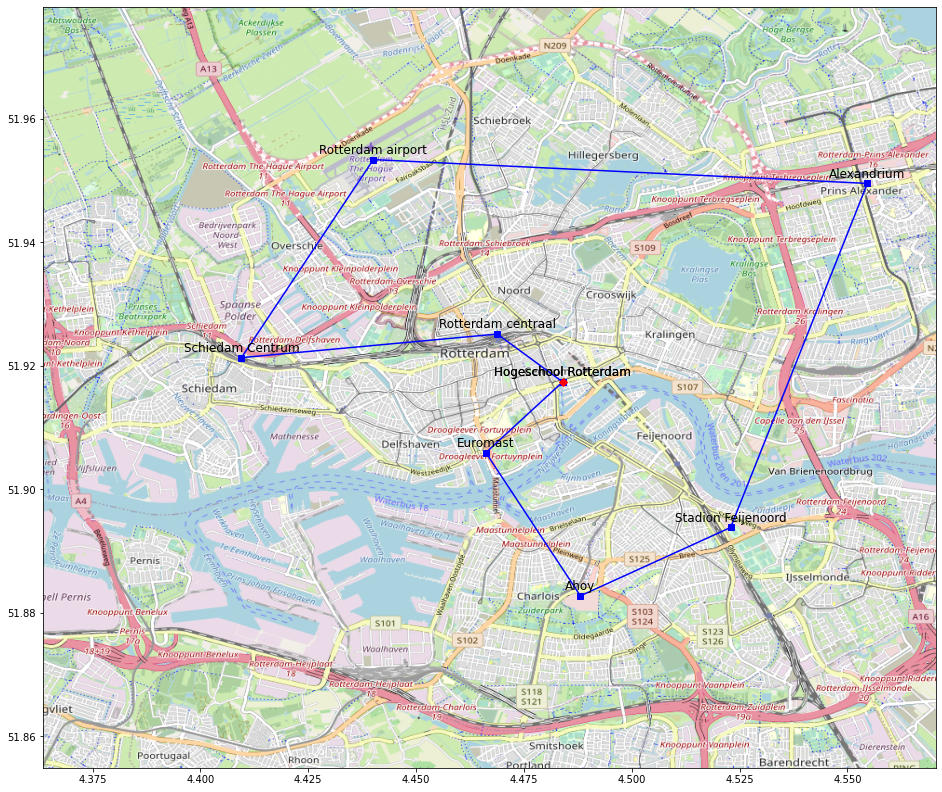

In [18]:
# map_BBox = (4.3635, 4.5705, 51.8549, 51.9781) # repeated here if not created before
map_path = load_from_jupyter_attachment()

fig, ax = plt.subplots(figsize = (16,14))
plot_map(map_path, map_BBox)
plot_trip(best_trip)
plt.ion()
plt.show()